In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from Bio import SeqIO
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import math

In [3]:
class TransformerClassifier(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers=3, dropout=0.1, use_pos_embedding=True):
        
        super(TransformerClassifier, self).__init__()
        
        self.use_pos_embedding = use_pos_embedding
        self.embedding = nn.Linear(input_dim, model_dim)
        
        if use_pos_embedding:
            self.pos_embedding = self.sinusoidal_positional_encoding(500, model_dim)

        
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, dim_feedforward=model_dim * 4, dropout=dropout, batch_first=True)
        
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.classifier = nn.Linear(model_dim, input_dim)

    def forward(self, x):
        x = self.embedding(x)
        if self.use_pos_embedding:
            x = x + self.pos_embedding[:x.size(1), :].unsqueeze(0)

        x = self.encoder(x)
        logits = self.classifier(x)
        return logits
    
    def sinusoidal_positional_encoding(self, max_len, model_dim):
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, model_dim, 2) *-(math.log(10000.0) / model_dim))
        pos_encoding = torch.zeros(max_len, model_dim)
        pos_encoding[:, 0::2] = torch.sin(position * div_term)
        pos_encoding[:, 1::2] = torch.cos(position * div_term)
        return pos_encoding


Ejercicio 9.0 Anlice el codigo. ¿Qué hiperparametros posee el modelo?. ¿Cuales de ellos
poseen un valor predeterminado de acuerdo al problema, que valores toma y por que?. ¿Por
que la capa lineal toma como input model_dim y cómo salida input_dim?

Hiperparametros del modelo:

- "Input_dim" es la dimension del tensor de entrada. Su valor esta predeterminado de acuerdo al problema. Por ejemplo en este caso queremos predecir una probabilidad para cada uno de los posibles 21 AAs.

- “Model_dim” es el tamaño del vector que representa cada token después de pasar por las
capas iniciales (embedding). Determina, por lo tanto, el tamaño de los vectores en el
mecanismo de atención y la salida de cada capa del codificador Transformer. (Es como el
tamaño de la representacion interna en una CNN o RNN)


- “Num_heads:” Representa el número de "cabezas" en el mecanismo de atención multi-head.
Recordemos que en el mecanismo cada “head” puede enfocarse en diferentes partes de la
entrada de manera independiente. Esto permite al modelo capturar una gama más amplia de
dependencias en los datos. O sea es equivalente los diferentes canales/filtros en una CNN.


- “Num_layers”. El numero de capas del codificador Transformer. Cada capa consta de una
atención multi-head, redes feed-forward y el skip connection. Las capas, al igual que las CNN y
RNN se pueden “apilar” una sobre otra.


- “Dropout” como ya vimos la fracción de dropout controla la regularización.
El “Posicional Encoding”, en un transformer se puede utilizar (o no) posicional encoding o
dfierentes sabores del mismo. En nuestro caso tenemos la opcion de aplicarlo o no.

Además de los hiperparámetros del modelo, tenemos los hiperparámetros del entrenamiento,
en este caso: la fracción del masking, y luego el numero de epocas, el batch_size y el learning
rate.

Ejercicio 9.1 a) Diseñe y escriba un algoritmo que le permita enmascarar de cada secuencia de
entrada un dado % (un hiperparámetro) de residuos y se obtenga: i) el tensor enmascarado
correspondiente ii) el tensor con los índices de los residuos correctos (que serà utilizado por la
LF) iii) una lista o tensor con los indices (el #res) de los residuos a enmascarar.

In [4]:
def leer_fasta(filepath):
    secuencias = []
    for record in SeqIO.parse(filepath, "fasta"):
        secuencias.append(str(record.seq))
    return secuencias

def one_hot_encoding(secuencias, aminoacidos="ACDEFGHIKLMNPQRSTVWY-"):

    aa_to_index = {aa: idx for idx, aa in enumerate(aminoacidos)}
    ohe_matrices = []
    
    for secuencia in secuencias:
        ohe_matrix = np.zeros((len(secuencia), len(aminoacidos)), dtype=np.float32)
        for i, aa in enumerate(secuencia):
            if aa in aa_to_index:
                ohe_matrix[i, aa_to_index[aa]] = 1.0
        ohe_matrices.append(ohe_matrix)
    
    return np.array(ohe_matrices)

def one_hot_to_AA(seq_one_hot, aminoacidos="ACDEFGHIKLMNPQRSTVWY-"):
    aa_to_index = {idx: aa for idx, aa in enumerate(aminoacidos)}
    secuencia = ""
    for i in range(len(seq_one_hot)):
        index = np.argmax(seq_one_hot[:, i])
        secuencia += aa_to_index[index]
    return secuencia

In [5]:
seqs = leer_fasta("NOPQ_cur.fasta")

In [6]:
seqs_OHE = one_hot_encoding(seqs)
seqs_OHE.shape

(2009, 203, 21)

In [7]:
def mask_random_pos(seqs_OHE, M):
    N, L, D = seqs_OHE.shape  # D=21

    masked_seq = np.copy(seqs_OHE)
    true_indices = []
    mask_positions = []

    for i in range(N):
        num_to_mask = int(L * M)
        pos_to_mask = np.random.choice(L, num_to_mask, replace=False)

        for j in pos_to_mask:
            aa_index = np.argmax(seqs_OHE[i, j])  # cuál era el aminoácido correcto
            true_indices.append(aa_index)
            mask_positions.append((i, j))
            masked_seq[i, j, :] = 0  

    true_indices = np.array(true_indices)

    return masked_seq, true_indices, mask_positions

In [59]:
masked_seq, i_masked, pos = mask_random_pos(seqs_OHE[0:1], 0.3)

In [68]:
print(f'AA enmascarado: {masked_seq[pos[0][0], pos[0][1]]}')
print(f'AA sin enmascarar: {seqs_OHE[pos[0][0], pos[0][1]]}')
print(f'Indice que fue enmascarado: {i_masked[0]}')

AA enmascarado: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
AA sin enmascarar: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Indice que fue enmascarado: 3


In [85]:
train_OHE, y_true, pos = mask_random_pos(seqs_OHE, 0.1)

In [92]:
train_OHE.shape

(2009, 203, 21)

c) Utilizando el MSA de las hemoglobinas truncadas (u otro) entrene el modelo con secuencias
enmascaradas como input y calculando la LF sólo para los residuos enmascarados. Analice los
resultados.

Epoch 1/20, Loss: 3.0136
Epoch 2/20, Loss: 2.5841
Epoch 3/20, Loss: 2.4141
Epoch 4/20, Loss: 2.3731
Epoch 5/20, Loss: 2.3437
Epoch 6/20, Loss: 2.3145
Epoch 7/20, Loss: 2.3032
Epoch 8/20, Loss: 2.3039
Epoch 9/20, Loss: 2.2987
Epoch 10/20, Loss: 2.2816
Epoch 11/20, Loss: 2.2639
Epoch 12/20, Loss: 2.2506
Epoch 13/20, Loss: 2.2391
Epoch 14/20, Loss: 2.2277
Epoch 15/20, Loss: 2.2079
Epoch 16/20, Loss: 2.1808
Epoch 17/20, Loss: 2.1552
Epoch 18/20, Loss: 2.1339
Epoch 19/20, Loss: 2.1084
Epoch 20/20, Loss: 2.0789


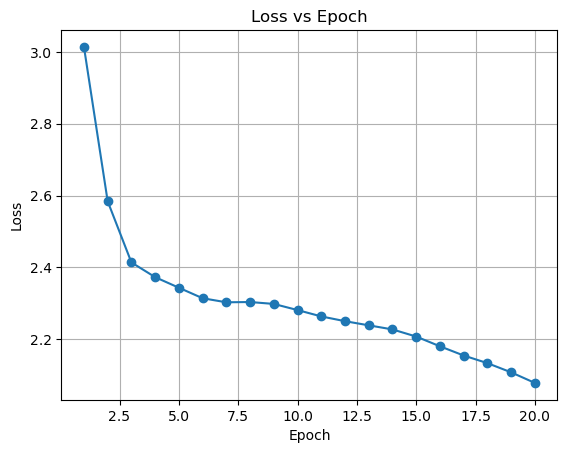

In [ ]:
input_dim = 21
model_dim = 64
num_heads = 4
num_epochs = 20

device = torch.device("cpu")
model = TransformerClassifier(input_dim, model_dim, num_heads).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

losses = []

# Conversión de datos
x_tensor = torch.tensor(train_OHE, dtype=torch.float32).to(device)   # (2009, 203, 21)
y_tensor = torch.tensor(y_true, dtype=torch.long).to(device)         # (N*(L*M),)
pos_tensor = torch.tensor(pos, dtype=torch.long).to(device)          # (N*(L*M), 2)

# Entrenamiento
model.train()
for epoch in range(num_epochs):
    optimizer.zero_grad()

    outputs = model(x_tensor)  # (2009, 203, 21)

    # Extraer solo los logits correspondientes a las posiciones enmascaradas
    masked_logits = outputs[pos_tensor[:, 0], pos_tensor[:, 1]]  # (N*M, 21)

    loss = criterion(masked_logits, y_tensor)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

plt.plot(range(1, num_epochs + 1), losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.grid(True)
plt.show()

Ejercicio 9.2. a) Analice la capacidad de su modelo en función de los diferentes
hiperparámetros. Recuerde que para dimensionar el posible sobre ajuste debe evaluar al
modelo con datos que no se utilizaron para el entrenamiento (por ejemplo puede dejar un 10%
de las secuencias fuera del entrenamiento, y evaluar la capacidad de prediccion de los
aminoácidos de las msimas, luego del masking).

In [30]:
def prepare_data(seqs, test_size=0.2, batch_size=30, M=0.1):

    seqs_OHE = one_hot_encoding(seqs)
    N = seqs_OHE.shape[0]

    indices = np.arange(N)
    train_idx, test_idx = train_test_split(indices, test_size=test_size, random_state=42)
    seqs_train = seqs_OHE[train_idx]
    seqs_test = seqs_OHE[test_idx]

    # Enmascarar todas las secuencias por separado (devuelve arrays planos)
    train_masked = []
    train_y = []
    train_pos = []

    for seq in seqs_train:
        masked_seq, true_idx, mask_pos = mask_random_pos(seq[np.newaxis, :, :], M)
        train_masked.append(masked_seq[0])
        train_y.append(true_idx)
        train_pos.append(np.array(mask_pos))

    test_masked = []
    test_y = []
    test_pos = []

    for seq in seqs_test:
        masked_seq, true_idx, mask_pos = mask_random_pos(seq[np.newaxis, :, :], M)
        test_masked.append(masked_seq[0])
        test_y.append(true_idx)
        test_pos.append(np.array(mask_pos))

    # Convertir a tensores
    x_train = torch.tensor(np.stack(train_masked), dtype=torch.float32)
    y_train = [torch.tensor(arr, dtype=torch.long) for arr in train_y]
    pos_train = [torch.tensor(arr, dtype=torch.long) for arr in train_pos]

    x_test = torch.tensor(np.stack(test_masked), dtype=torch.float32)
    y_test = [torch.tensor(arr, dtype=torch.long) for arr in test_y]
    pos_test = [torch.tensor(arr, dtype=torch.long) for arr in test_pos]

    # Creamos TensorDatasets con solo las secuencias para usar DataLoader y luego collate para procesar etiquetas y posiciones
    train_seq_dataset = TensorDataset(x_train)
    test_seq_dataset = TensorDataset(x_test)

    def collate_fn(batch):
        # batch es lista de tuplas con un tensor (x) cada uno
        x_batch = torch.stack([item[0] for item in batch])  # (B, L, D)
        batch_size = x_batch.size(0)

        y_batch = []
        pos_batch = []

        for i, (seq,) in enumerate(batch):
            y_batch.append(y_train[i])
            # pos_train[i] tiene (M_i, 2) con (0, pos_res)
            # Cambiamos la primer columna para indicar el índice en el batch
            seq_idx = torch.full((pos_train[i].shape[0], 1), i, dtype=torch.long)
            pos_rel = torch.cat([seq_idx, pos_train[i][:, 1:]], dim=1)
            pos_batch.append(pos_rel)

        y_batch = torch.cat(y_batch)
        pos_batch = torch.cat(pos_batch)

        return x_batch, y_batch, pos_batch

    train_loader = DataLoader(train_seq_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    test_loader = DataLoader(test_seq_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    return train_loader, test_loader



In [31]:
train_loader, test_loader = prepare_data(seqs)

In [40]:
model_dim = 64
input_dim = 21
num_heads = 4
num_layers = 1

device = torch.device("cpu")

num_epochs = 20

model = TransformerClassifier(input_dim, model_dim, num_heads, num_layers=num_layers, use_pos_embedding=True).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_losses = []
test_losses = []
test_accuracies = []

model.train()

for epoch in range(1, num_epochs + 1):
    epoch_loss = 0.0

    for x_batch, y_batch, pos_batch in train_loader:
        x_batch = x_batch.squeeze(0)       # (B, L, 21)
        y_batch = y_batch.squeeze(0)       # (B*M,)
        pos_batch = pos_batch.squeeze(0)   # (B*M, 2)

        optimizer.zero_grad()
        outputs = model(x_batch)  # (B, L, 21)
        masked_logits = outputs[pos_batch[:, 0], pos_batch[:, 1]]  # (B*M, 21)

        loss = criterion(masked_logits, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    train_losses.append(epoch_loss / len(train_loader))
    
    print(f"Epoch {epoch}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}")

    # Evaluación cada 5 épocas
    if epoch % 5 == 0:
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for x_batch, y_batch, pos_batch in test_loader:
                x_batch = x_batch.squeeze(0)
                y_batch = y_batch.squeeze(0)
                pos_batch = pos_batch.squeeze(0)

                outputs = model(x_batch)
                masked_logits = outputs[pos_batch[:, 0], pos_batch[:, 1]]
                loss = criterion(masked_logits, y_batch)

                test_loss += loss.item()
                preds = torch.argmax(masked_logits, dim=1)
                correct += (preds == y_batch).sum().item()
                total += y_batch.size(0)

        acc = correct / total
        avg_test_loss = test_loss / len(test_loader)

        test_losses.append(avg_test_loss)
        test_accuracies.append(acc)

        print(f"  ➤ Test Loss: {avg_test_loss:.4f}, Accuracy: {acc:.4f}")
        model.train()

Epoch 1/20, Train Loss: 2.0260
Epoch 2/20, Train Loss: 1.3171
Epoch 3/20, Train Loss: 1.0506
Epoch 4/20, Train Loss: 0.8757
Epoch 5/20, Train Loss: 0.7644
  ➤ Test Loss: 0.6496, Accuracy: 0.7183
Epoch 6/20, Train Loss: 0.7035
Epoch 7/20, Train Loss: 0.6711
Epoch 8/20, Train Loss: 0.6523
Epoch 9/20, Train Loss: 0.6377
Epoch 10/20, Train Loss: 0.6253
  ➤ Test Loss: 0.5601, Accuracy: 0.7229
Epoch 11/20, Train Loss: 0.6207
Epoch 12/20, Train Loss: 0.6118
Epoch 13/20, Train Loss: 0.6028
Epoch 14/20, Train Loss: 0.6015
Epoch 15/20, Train Loss: 0.5975
  ➤ Test Loss: 0.5449, Accuracy: 0.7243
Epoch 16/20, Train Loss: 0.5924
Epoch 17/20, Train Loss: 0.5893
Epoch 18/20, Train Loss: 0.5888
Epoch 19/20, Train Loss: 0.5831
Epoch 20/20, Train Loss: 0.5835
  ➤ Test Loss: 0.5373, Accuracy: 0.7257


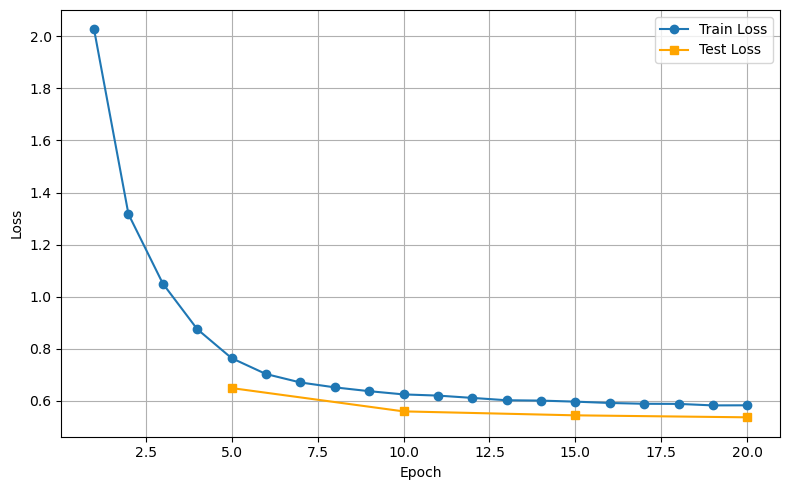

In [41]:
epochs = list(range(1, num_epochs + 1))
test_eval_epochs = list(range(5, num_epochs + 1, 5))  # Solo donde se calculó test loss

# Gráfico
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(test_eval_epochs, test_losses, label='Test Loss', marker='s', color='orange')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

| Modelo / Capacidad                   | LF Train | LF Test | Accuracy% Test |
|-------------------------------------|----------|---------|----------------|
| md=32, nh=4, nl=1, dout=0.1, PE=True|  0.6710  |  0.5734  |      72.4      |
| md=32, nh=4, nl=1, dout=0.1, PE=False|  1.72  | 1.73  |      51.48      |
| md=32, nh=8, nl=1, dout=0.1, PE=True|  0.67  |  0.5748  |      72.2      |
| md=64, nh=4, nl=1, dout=0.1, PE=True|  0.58  |  0.537  |      72.57      |

Por azar, la accuracy seria 1/21 * 100 = 4.76%
Siendo la accuracy de estos modelos muy superior a lo esperado por azar

# 9.3 Interpretación del modelo

In [42]:
class TransformerClassifier(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers=3, dropout=0.1, use_pos_embedding=True):
        
        super(TransformerClassifier, self).__init__()
        
        self.use_pos_embedding = use_pos_embedding
        self.embedding = nn.Linear(input_dim, model_dim)
        
        if use_pos_embedding:
            self.pos_embedding = self.sinusoidal_positional_encoding(500, model_dim)

        
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, dim_feedforward=model_dim * 4, dropout=dropout, batch_first=True)
        
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.classifier = nn.Linear(model_dim, input_dim)

    def forward(self, x, return_attention=False):
        x = self.embedding(x)
        if self.use_pos_embedding:
            x = x + self.pos_embedding[:x.size(1), :].unsqueeze(0)
        if return_attention:
            attentions = []
            for layer in self.encoder.layers:
                # Get attention weights for all heads
                x, attn_weights = layer.self_attn(x, x, x, need_weights=True, average_attn_weights=False)
                attentions.append(attn_weights)
                x = layer.norm1(x + layer.dropout1(x))

                x=layer.norm2(x+layer.dropout2(layer.linear2(layer.dropout(layer.activation(layer.linear1(x))))))
            logits = self.classifier(x)
            return logits, attentions
        else:
            x = self.encoder(x)
            logits = self.classifier(x)
            return logits
    
    def sinusoidal_positional_encoding(self, max_len, model_dim):
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, model_dim, 2) *-(math.log(10000.0) / model_dim))
        pos_encoding = torch.zeros(max_len, model_dim)
        pos_encoding[:, 0::2] = torch.sin(position * div_term)
        pos_encoding[:, 1::2] = torch.cos(position * div_term)
        return pos_encoding

In [52]:
masked_input, true_indices, mask_positions = mask_random_pos(seqs_OHE, 0.1)
masked_input = torch.tensor(masked_input)

In [68]:
model = TransformerClassifier(input_dim, model_dim, 8, num_layers=num_layers, use_pos_embedding=True).to(device)
model.eval()
output, attentions = model(masked_input[0:1], return_attention=True)

In [69]:
attentions[0].shape

torch.Size([1, 8, 203, 203])

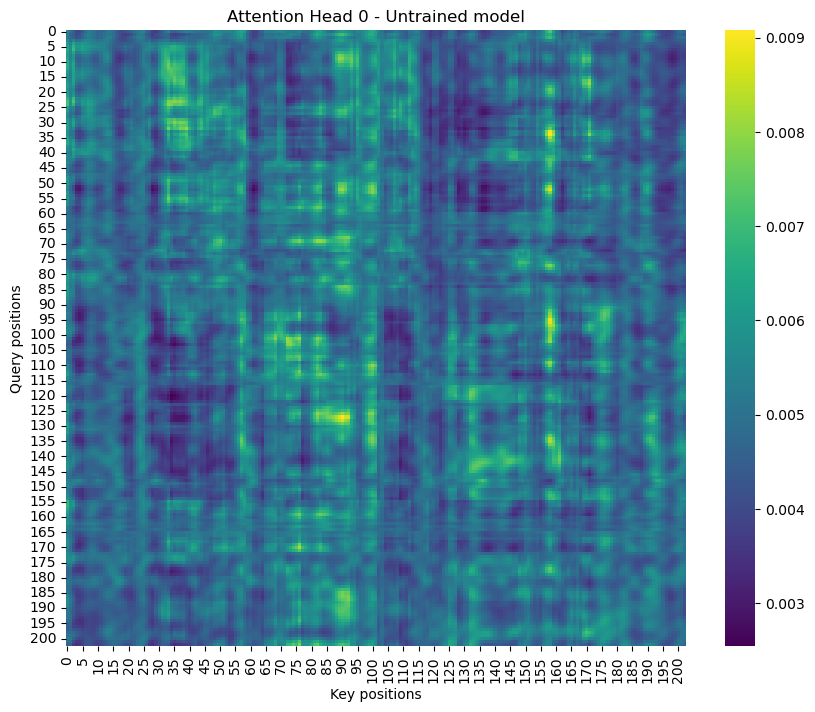

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extraer matriz de atención del head 0, secuencia 0
attention_matrix = attentions[0][0, 0].detach().cpu().numpy()  # (203, 203)

plt.figure(figsize=(10, 8))
sns.heatmap(attention_matrix, cmap='viridis')
plt.title("Attention Head 0 - Untrained model")
plt.xlabel("Key positions")
plt.ylabel("Query positions")
plt.show()

In [73]:
model_dim = 64
input_dim = 21
num_heads = 4
num_layers = 1

device = torch.device("cpu")

num_epochs = 20

model = TransformerClassifier(input_dim, model_dim, num_heads, num_layers=num_layers, use_pos_embedding=True).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_losses = []
test_losses = []
test_accuracies = []

model.train()

for epoch in range(1, num_epochs + 1):
    epoch_loss = 0.0

    for x_batch, y_batch, pos_batch in train_loader:
        x_batch = x_batch.squeeze(0)       # (B, L, 21)
        y_batch = y_batch.squeeze(0)       # (B*M,)
        pos_batch = pos_batch.squeeze(0)   # (B*M, 2)

        optimizer.zero_grad()
        outputs = model(x_batch)  # (B, L, 21)
        masked_logits = outputs[pos_batch[:, 0], pos_batch[:, 1]]  # (B*M, 21)

        loss = criterion(masked_logits, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    train_losses.append(epoch_loss / len(train_loader))
    
    print(f"Epoch {epoch}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}")

    # Evaluación cada 5 épocas
    if epoch % 5 == 0:
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for x_batch, y_batch, pos_batch in test_loader:
                x_batch = x_batch.squeeze(0)
                y_batch = y_batch.squeeze(0)
                pos_batch = pos_batch.squeeze(0)

                outputs = model(x_batch)
                masked_logits = outputs[pos_batch[:, 0], pos_batch[:, 1]]
                loss = criterion(masked_logits, y_batch)

                test_loss += loss.item()
                preds = torch.argmax(masked_logits, dim=1)
                correct += (preds == y_batch).sum().item()
                total += y_batch.size(0)

        acc = correct / total
        avg_test_loss = test_loss / len(test_loader)

        test_losses.append(avg_test_loss)
        test_accuracies.append(acc)

        print(f"  ➤ Test Loss: {avg_test_loss:.4f}, Accuracy: {acc:.4f}")
        model.train()

Epoch 1/20, Train Loss: 1.9803
Epoch 2/20, Train Loss: 1.2856
Epoch 3/20, Train Loss: 1.0073
Epoch 4/20, Train Loss: 0.8494
Epoch 5/20, Train Loss: 0.7519
  ➤ Test Loss: 0.6463, Accuracy: 0.7197
Epoch 6/20, Train Loss: 0.6972
Epoch 7/20, Train Loss: 0.6688
Epoch 8/20, Train Loss: 0.6436
Epoch 9/20, Train Loss: 0.6319
Epoch 10/20, Train Loss: 0.6214
  ➤ Test Loss: 0.5586, Accuracy: 0.7215
Epoch 11/20, Train Loss: 0.6156
Epoch 12/20, Train Loss: 0.6052
Epoch 13/20, Train Loss: 0.5989
Epoch 14/20, Train Loss: 0.5971
Epoch 15/20, Train Loss: 0.5930
  ➤ Test Loss: 0.5429, Accuracy: 0.7239
Epoch 16/20, Train Loss: 0.5891
Epoch 17/20, Train Loss: 0.5850
Epoch 18/20, Train Loss: 0.5800
Epoch 19/20, Train Loss: 0.5788
Epoch 20/20, Train Loss: 0.5755
  ➤ Test Loss: 0.5373, Accuracy: 0.7239


In [74]:
model.eval()
output, attentions = model(masked_input[0:1], return_attention=True)

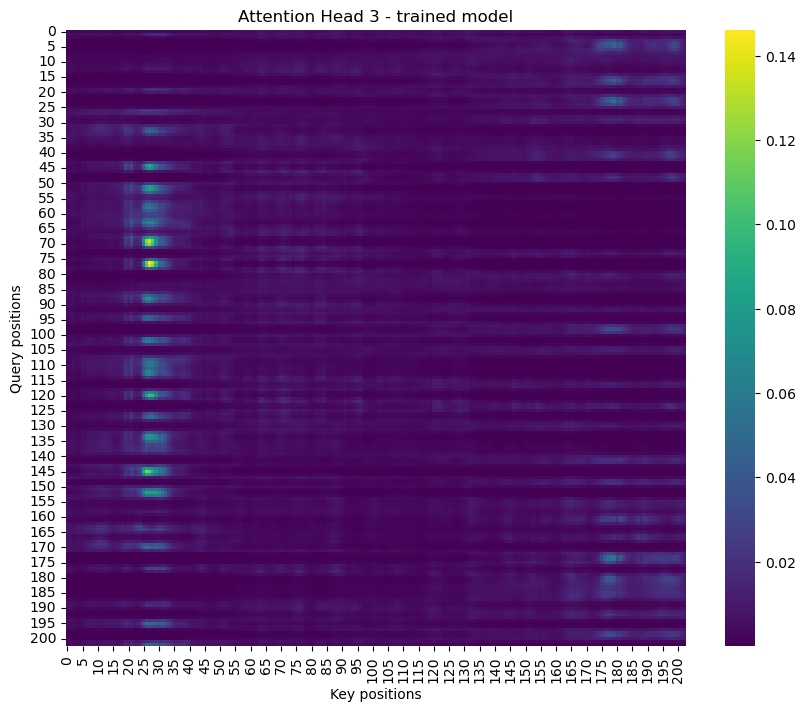

In [83]:
attention_matrix = attentions[0][0, 2].detach().cpu().numpy()  # (203, 203)

plt.figure(figsize=(10, 8))
sns.heatmap(attention_matrix, cmap='viridis')
plt.title("Attention Head 3 - trained model")
plt.xlabel("Key positions")
plt.ylabel("Query positions")
plt.show()

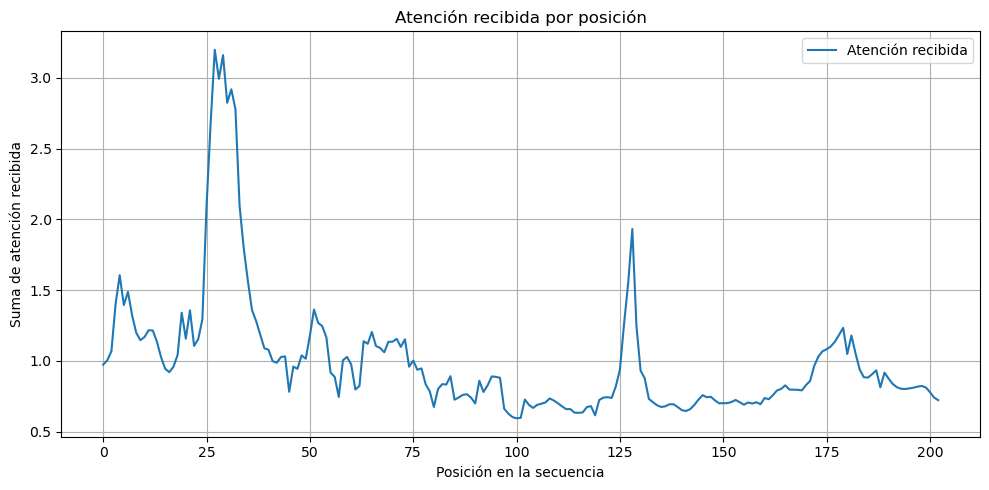

In [88]:
attn_tensor = attentions[0][0]  # Shape: (num_heads, L, L)

# Promediar sobre las cabezas
attn_mean = attn_tensor.mean(dim=0)  # Shape: (L, L)

# Sumar sobre las filas (queries) para obtener atención recibida (por columnas = keys)
attn_received = attn_mean.sum(dim=0).detach().cpu().numpy()  # Shape: (L,)

plt.figure(figsize=(10, 5))
plt.plot(attn_received, label='Atención recibida')
plt.xlabel("Posición en la secuencia")
plt.ylabel("Suma de atención recibida")
plt.title("Atención recibida por posición")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()